In [1]:
import os
import pathlib
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from keras import Sequential,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks  import ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.keras import layers, models

from tensorflow.keras.preprocessing.image import load_img

### Data Reading / Data Understanding

In [2]:
# Defining Path for images
train_images_path = '../Org Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_images_path = '../Org Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [3]:
# Getting count of Images 
train_images = pathlib.Path(train_images_path)
image_count_train = len(list(train_images.glob('*/*.jpg')))
print(image_count_train)

2239


In [4]:
# Getting count of Images 
test_images = pathlib.Path(test_images_path)
image_count_test = len(list(test_images.glob('*/*.jpg')))
print(image_count_test)

118


### Dataset Creation

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [6]:
# Loading the train data

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               batch_size=BATCH_SIZE, 
                                                               label_mode='categorical',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Storing Class Names in a variable for further reference 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
# Loading the validation data

val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             batch_size=BATCH_SIZE, 
                                                             label_mode='categorical',
                                                             subset='validation')
 

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Model Building & training  

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# 1. Building the CNN Model
model = models.Sequential([
    
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

In [11]:
# Defining  optimiser and loss function
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])


In [12]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [ ]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs 
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations 

 - The model is overfitting as the training accuracy is significantly higher than the validation accuracy.
 - the model is learning, but there is room for improvement in terms of overfitting and validation performance.

### Model Building & training - 2

In [ ]:
# Due to limited training data , the above model we created seems to overfit , lets create a new model with a layer for data 
# augmentation so that model can have training on more images that would be generated based on below augmentation attributes

In [14]:
# Adding data augmentation as a layer helps the model to avoid overfitting by
# artificially increasing the diversity of the training dataset

data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# 1. Building the CNN Model
model = models.Sequential([
    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    data_augmentation,
    
    # Convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

In [17]:
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                 

In [ ]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs 
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Building & training - 3

In [19]:
##Find the distribution of classes in the training dataset
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(train_images_path)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [20]:
train_images_path

'../Org Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

In [22]:
train_images_path = '../Augmented Skin cancer ISIC The International Skin Imaging Collaboration/Train/' 

In [23]:
train_images = pathlib.Path(train_images_path)
test_images = pathlib.Path(test_images_path)

In [33]:
import Augmentor
# max_images = max([len(os.listdir(train_images / i)) for i in class_names])
# max_images = round(max_images / 100) * 100 
addCount = 1000
for i in class_names:
    train_images_sub = train_images /  i
    classes_image_count_train = len(list(train_images_sub.glob('*.jpg')))
    p = Augmentor.Pipeline(train_images_sub)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(addCount)

# On a side note , would like to add here that I initially thought to get the maximum number of images for a
# class which was coming around 463 , so Ideally to remove the class imbalance , we can take a round of max to its nearest 
# 100 which was coming 500. But having this set of images was failing to achieve the accuracy , my accuracy at that point
# was coming around 50 to 60 % only , so I added 500 more images to each of the class and the model performance got increase
# which means that apart of taking care of class imbalance , we should also take care of having a good count 
# of images so that model can learn better 

Initialised with 114 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E20910CD0>: 100%|██████████| 1000/1000 [00:02<00:00, 410.32 Samples/s]                 


Initialised with 376 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E2095F190>: 100%|██████████| 1000/1000 [00:02<00:00, 410.46 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E6ACAF400>: 100%|██████████| 1000/1000 [00:02<00:00, 397.42 Samples/s]                 


Initialised with 438 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x20E2094B8B0>: 100%|██████████| 1000/1000 [00:12<00:00, 80.42 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E20679EB0>: 100%|██████████| 1000/1000 [00:11<00:00, 86.18 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E20694730>: 100%|██████████| 1000/1000 [00:02<00:00, 375.45 Samples/s]                 


Initialised with 77 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x20E1DA90DF0>: 100%|██████████| 1000/1000 [00:06<00:00, 163.67 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E1F460610>: 100%|██████████| 1000/1000 [00:02<00:00, 374.07 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ..\Augmented Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20E1F87C700>: 100%|██████████| 1000/1000 [00:02<00:00, 373.37 Samples/s]                  


In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                               batch_size=BATCH_SIZE, 
                                                               label_mode='categorical',
                                                               subset='training')

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [36]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_images,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(IMG_HEIGHT,IMG_WIDTH),
                                                             batch_size=BATCH_SIZE, 
                                                             label_mode='categorical',
                                                             subset='validation')
 

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [60]:
model = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3)), 
    
    #First Convulation layer
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    #First Convulation layer
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    #First Convulation layer
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),   
    
    layers.Dropout(0.5),
    
    #Flatten Layer
    ##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
    layers.Flatten(),

    #Dense Layer
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.25),
    
    #Dense Layer with softmax activation function.
    #Softmax is an activation function that scales numbers/logits into probabilities.
    layers.Dense(len(class_names),activation='softmax')

])


In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [63]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_33 (Conv2D)          (None, 41, 41, 128)     

In [64]:
epochs = 30

In [65]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[reduce_lr])

Epoch 1/30
281/281 [==============================] - 126s 446ms/step - loss: 1.8565 - accuracy: 0.2887 - val_loss: 1.4907 - val_accuracy: 0.4085 - lr: 0.0010
Epoch 2/30
281/281 [==============================] - 145s 516ms/step - loss: 1.3823 - accuracy: 0.4730 - val_loss: 1.2999 - val_accuracy: 0.5073 - lr: 0.0010
Epoch 3/30
281/281 [==============================] - 136s 482ms/step - loss: 1.1823 - accuracy: 0.5552 - val_loss: 1.0894 - val_accuracy: 0.6070 - lr: 0.0010
Epoch 4/30
281/281 [==============================] - 136s 484ms/step - loss: 1.0087 - accuracy: 0.6219 - val_loss: 0.8641 - val_accuracy: 0.6791 - lr: 0.0010
Epoch 5/30
281/281 [==============================] - 129s 458ms/step - loss: 0.8761 - accuracy: 0.6779 - val_loss: 0.8115 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 6/30
281/281 [==============================] - 126s 447ms/step - loss: 0.7727 - accuracy: 0.7159 - val_loss: 0.6799 - val_accuracy: 0.7534 - lr: 0.0010
Epoch 7/30
281/281 [==========================

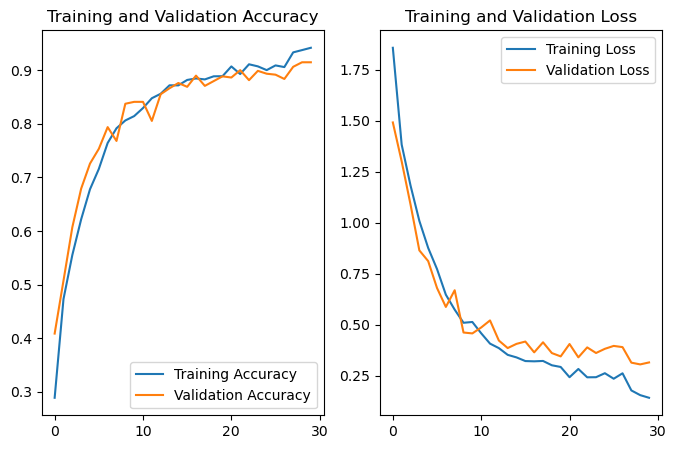

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Above charts clearly denotes that model has been able to achieve a good performance on adding augmentation techniques to the 
existing set of images. However, the model seems to perform well around 20 epoch and post that point , validation accuracy 
has stopped improving and also the difference between training and validation accuracy is also getting increased after 20 epochs

In [ ]:
!pip install tabulate

In [67]:
from tabulate import tabulate
data = []
for epoch, train_acc, val_acc, train_loss, val_loss in zip(epochs_range, acc, val_acc, loss, val_loss):
    data.append([epoch, train_acc, val_acc, train_loss, val_loss])

headers = ["Epochs", "Training Accuracy", "Validation Accuracy", "Training Loss", "Validation Loss"]

table = tabulate(data, headers, tablefmt="pipe")
print(table)

|   Epochs |   Training Accuracy |   Validation Accuracy |   Training Loss |   Validation Loss |
|---------:|--------------------:|----------------------:|----------------:|------------------:|
|        0 |            0.288701 |              0.408545 |        1.85648  |          1.49075  |
|        1 |            0.472976 |              0.507343 |        1.38227  |          1.2999   |
|        2 |            0.55516  |              0.607032 |        1.18228  |          1.08937  |
|        3 |            0.621886 |              0.679128 |        1.00868  |          0.864067 |
|        4 |            0.677936 |              0.725857 |        0.876091 |          0.81152  |
|        5 |            0.715859 |              0.753449 |        0.772661 |          0.679851 |
|        6 |            0.764346 |              0.793947 |        0.647053 |          0.587058 |
|        7 |            0.791815 |              0.768135 |        0.573847 |          0.668792 |
|        8 |            0.8063

In [68]:
def getMaxRecordForParameters(colIndex, tag):
    # Find the maximum value based on colIndex
    max_data = max(data, key=lambda x: x[colIndex])
    max_value = max_data[colIndex]
    epoch_with_max_value = max_data[0]
    print(f"{tag}: {max_value} (Epoch {epoch_with_max_value})")

In [69]:
# Find the maximum training accuracy and corresponding epoch number
getMaxRecordForParameters(1,"Training Accuracy")
getMaxRecordForParameters(2,"Validation Accuracy") 

Training Accuracy: 0.9420596361160278 (Epoch 29)
Validation Accuracy: 0.9149977564811707 (Epoch 28)


Training Accuracy: It reaches a very high value of approximately 97% after 25 epochs. This high training accuracy indicates that the model is overfitting data and even might be memorizing the data since the validation accuracy is not near to this.

Validation Accuracy: On the other hand, the validation accuracy, which is a measure of the model's performance on unseen data, reaches around 88% but seems to stay in a near by line after epoch 19. This suggests that the model's ability to generalize to new, unseen data is not improving beyond that point.

The high training accuracy beyond epoch 15 suggests that the model may be memorizing the training data, which is often a sign of overfitting and can lead to reduced performance on validation or test data. It would be good idea to keep epochs up to 20 (Ideally 15 is serving the purpose )  and not 30

## Testing the Model

1/1 [==============================] - 0s 28ms/step
Actual Class nevus
Predictive Class nevus


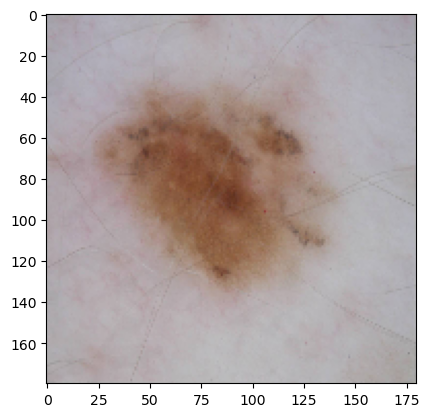

In [86]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )